# NIRSpec G395H data analysis I. Finding calibrated data

In this notebook, we will produce corrected data from `rateints` JWST data.

We will directly use `rateints` products from the MAST portal. However, we still want to produce corrected data from those files, e.g., finding bad pixels and correcting them. We will also perform background subtraction on those frames.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jwst import datamodels
from poetss import poetss
from stark import reduce
from tqdm import tqdm
import os
import utils

2025-03-04 22:37:28,470 - stpipe - WARNING - /Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Ramp_NRSG395H'
pout = p1 + '/NRSG395H/Outputs/Tests'

fname = 'jw01366003001_04101_00001-seg001_nrs1_rateints.fits'

We already have `rateints` data -- let's load the data, create a badpixel map (or, rather access the badpixel map from the data products) and visualise the data.

<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>
Percentage of bad-pixels: 6.3392 %


Text(0.5, 1.0, 'Example data')

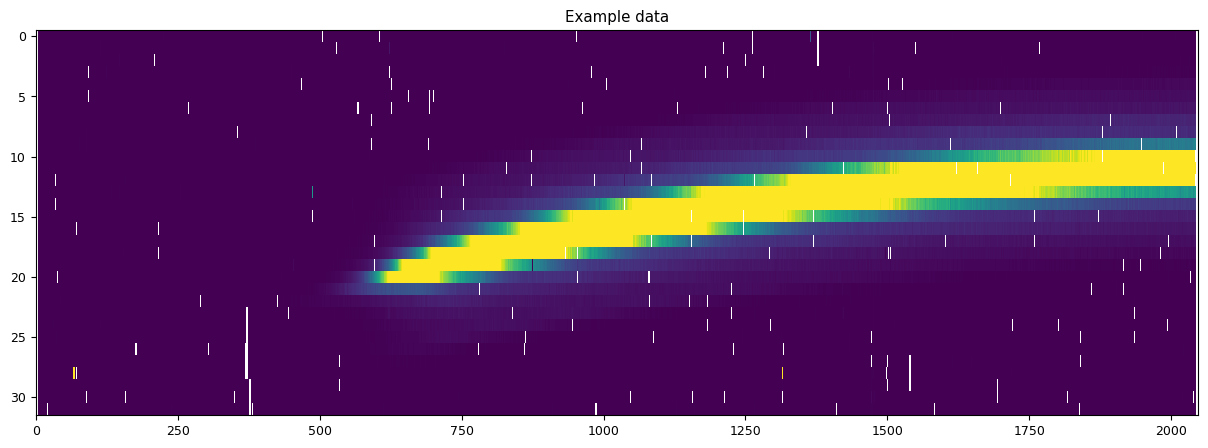

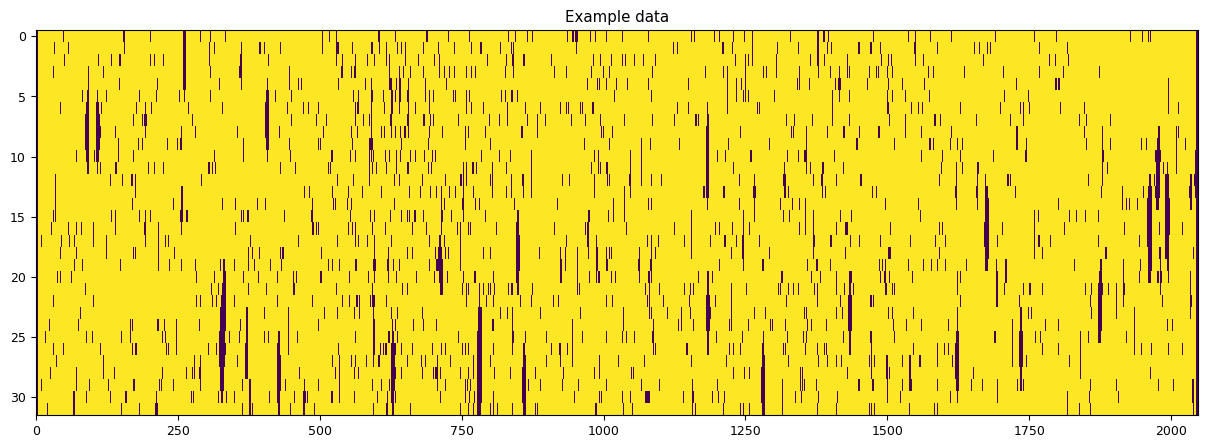

In [3]:
rate_ints = datamodels.open(pin + '/' + fname)
nint = np.random.randint(0, rate_ints.data.shape[0])
print(rate_ints)

## Time
times_bjd = rate_ints.int_times['int_mid_BJD_TDB']

## Bad-pixel map
dq = rate_ints.dq
mask = np.ones(dq.shape)
mask[dq > 0] = 0.

print('Percentage of bad-pixels: {:.4f} %'.format((1 - np.sum(mask) / ( mask.shape[0] * mask.shape[1] * mask.shape[2] ) ) * 100))

## Visualise the data and bad-pixel map (for a random integration)
plt.figure(figsize=(15,5))
im = plt.imshow(rate_ints.data[nint,:,:], interpolation='none', aspect='auto')
im.set_clim([0,1e2])
plt.title('Example data')

plt.figure(figsize=(15,5))
im = plt.imshow(mask[nint,:,:], interpolation='none', aspect='auto')
#im.set_clim([0,1e2])
plt.title('Example data')

About 6% of pixels are bad, but I think majority of them are from edges, maybe also, the JWST pipeline may have flagged many points incorrectly as cosmics during the jump step?! But for the purpose of this analysis it is fine.

Now that we have data, let's first correct it, i.e., correct for NaN in the data and error array (and add those pixels in the badpixel map), correct for all zeros in the error array, another manual search for cosmics etc.

In [4]:
print('>>>> --- Correcting errorbars (for zeros and NaNs)...')
## Correct errorbars
med_err = np.nanmedian(rate_ints.err.flatten())
## Changing Nan's and zeros in error array with median error
corr_err1 = np.copy(rate_ints.err)
corr_err2 = np.where(rate_ints.err != 0., corr_err1, med_err)                     # Replacing error == 0 with median error
corrected_errs = np.where(np.isnan(rate_ints.err) != True, corr_err2, med_err)    # Replacing error == Nan with median error
print('>>>> --- Done!!')

>>>> --- Correcting errorbars (for zeros and NaNs)...
>>>> --- Done!!


In [5]:
print('>>>> --- Creating a bad-pixel map...')
## Making a bad-pixel map
mask_bp1 = np.ones(rate_ints.data.shape)
mask_bp2 = np.where(rate_ints.err != 0., mask_bp1, 0.)                 # This will place 0 in mask where errorbar == 0
mask_bp3 = np.where(np.isnan(rate_ints.err) != True, mask_bp2, 0.)     # This will place 0 in mask where errorbar is Nan
#mask_badpix = np.where(dq == 0., mask_bp3, 0.)                               # This will place 0 in mask where darkdq != 0
mask_badpix = mask * mask_bp3                                                 # Adding those pixels which are identified as bad by the pipeline (and hence 0)

## Mask with cosmic rays
### Essentially this mask will add 0s in the places of bad pixels...
mask_bcr = utils.identify_crays(rate_ints.data, mask_badpix)
print('>>>> --- Done!!')

>>>> --- Creating a bad-pixel map...
>>>> --- Done!!


Total per cent of masked points: 6.3543 %


Text(0.5, 1.0, 'Bad-pixels for an arbitrary integration')

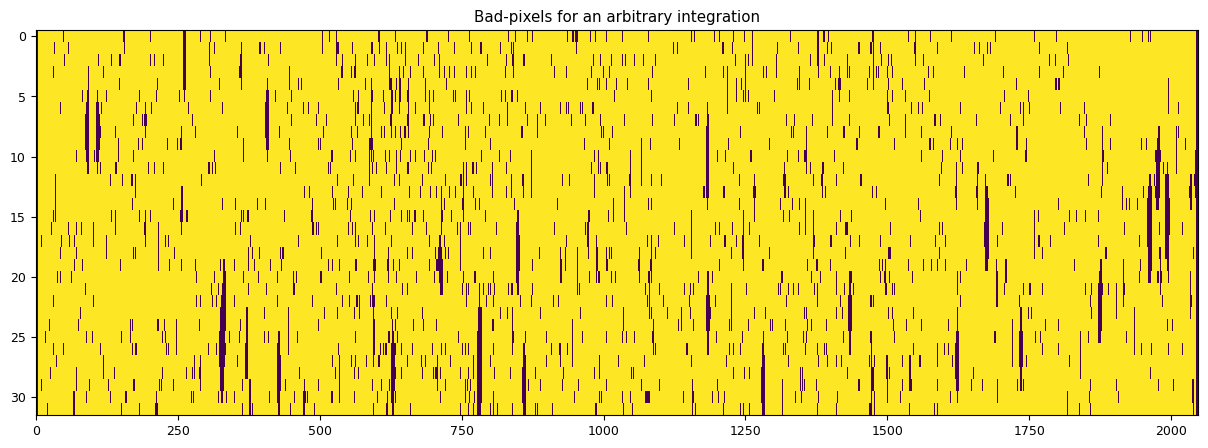

In [6]:
print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask_bcr) / (mask_bcr.shape[0] * mask_bcr.shape[1] * mask_bcr.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask_bcr[nint,:,:], interpolation='none', aspect='auto')
plt.title('Bad-pixels for an arbitrary integration')
#plt.xlim([512,1536])

In [7]:
print('>>>> --- Correcting data...')
corrected_data = np.copy(rate_ints.data)
corrected_data[mask_bcr == 0] = np.nan
for i in range(corrected_data.shape[0]):
    corrected_data[i,:,:] = utils.replace_nan(corrected_data[i,:,:])
print('>>>> --- Done!!')

>>>> --- Correcting data...
>>>> --- Done!!


Finally, we will perform a column by column background subtraction. However, for that, we need to define the background region first. Since the spectral trace is curved, this is not an easy task. We will first estimate the trace location and then create a background mask based on that.

Text(0.5, 1.0, 'Example data with the location of spectral trace')

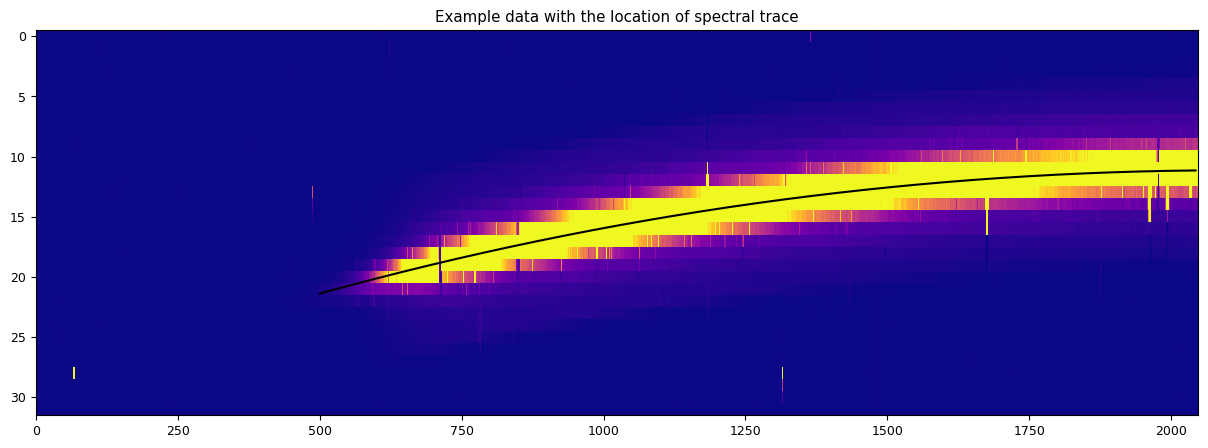

In [8]:
# Finding trace
cent_cub1 = poetss.find_trace_cof(clean_cube=corrected_data[:,:,500:2044], margin=5)
trace1, dx1 = poetss.fit_multi_trace(cent_mat=cent_cub1, deg=3, clip=3)
xpos = np.arange(500, 2044, 1)

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], interpolation='none', aspect='auto', cmap='plasma')
im.set_clim([0,1e2])
plt.plot(xpos, trace1, 'k-')
plt.title('Example data with the location of spectral trace')

Okay, so we will define background as all those pixels which are ~7 pixels away from the trace location.

Text(0.5, 1.0, 'Example data with the location of spectral trace and background mask')

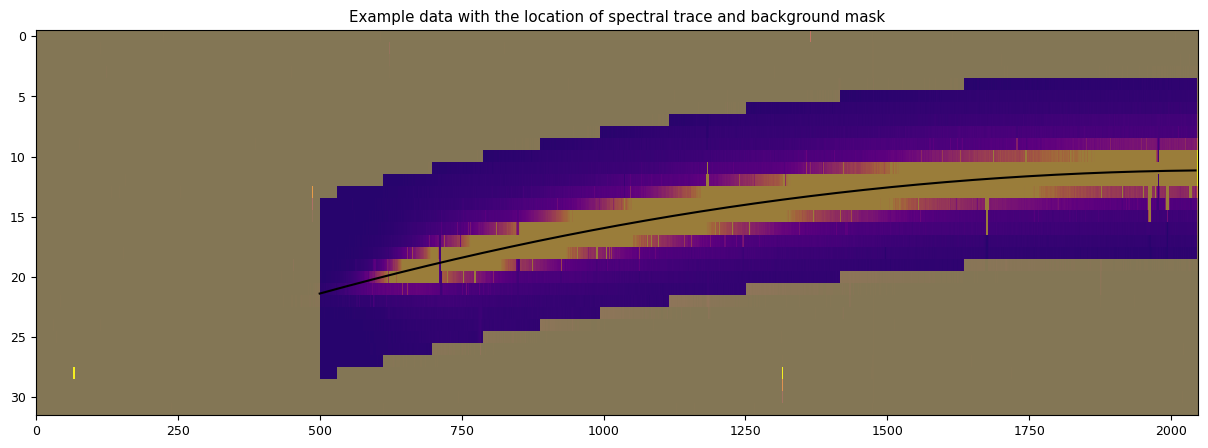

In [9]:
mask_bkg = np.ones(corrected_data[nint,:,:].shape)
for i in range(len(xpos)):
    mask_bkg[int(trace1[i]-7):int(trace1[i]+7+1), int(xpos[i])] = 0.

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], interpolation='none', aspect='auto', cmap='plasma')
plt.imshow(mask_bkg, interpolation='none', aspect='auto', alpha=0.5)
im.set_clim([0,1e2])
plt.plot(xpos, trace1, 'k-')
plt.title('Example data with the location of spectral trace and background mask')

Alright! We will now perform a column-by-column background subtraction on this data:

In [10]:
corrected_data_bkg = np.ones(corrected_data.shape)
for i in tqdm(range(corrected_data.shape[0])):
    corrected_data_bkg[i,:,:], _ = reduce.col_by_col_bkg_sub(corrected_data[i,:,:], mask=mask_bkg*mask_bcr[i,:,:])

100%|██████████| 155/155 [00:07<00:00, 21.79it/s]


Text(0, 0.5, 'Counts')

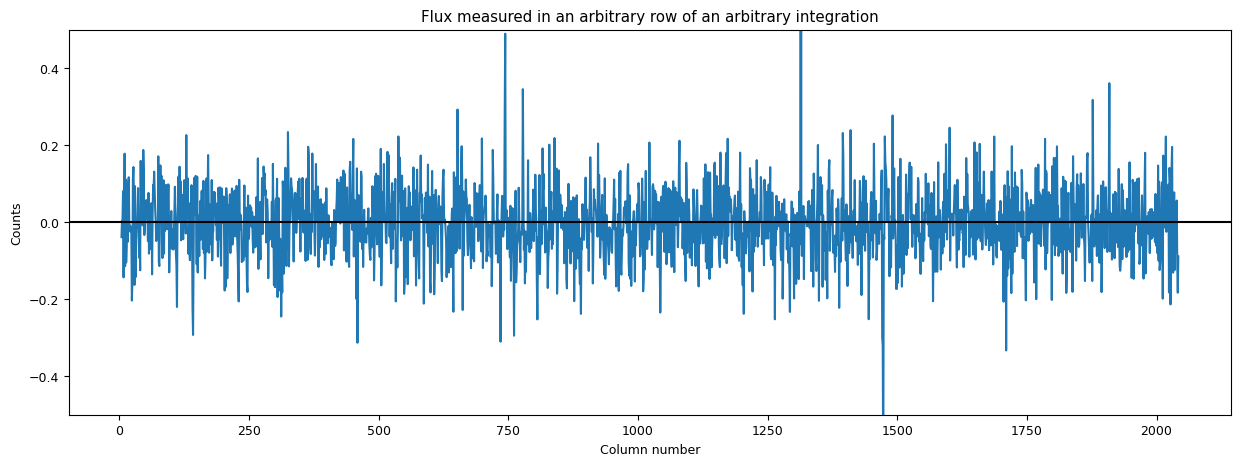

In [11]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg[nint,30,:])
plt.axhline(0., color='k')
plt.title('Flux measured in an arbitrary row of an arbitrary integration')
plt.xlabel('Column number')
plt.ylim([-0.5, 0.5])
plt.ylabel('Counts')

Text(0.5, 1.0, 'Flux level in an arbitrary column of an arbitrary integration')

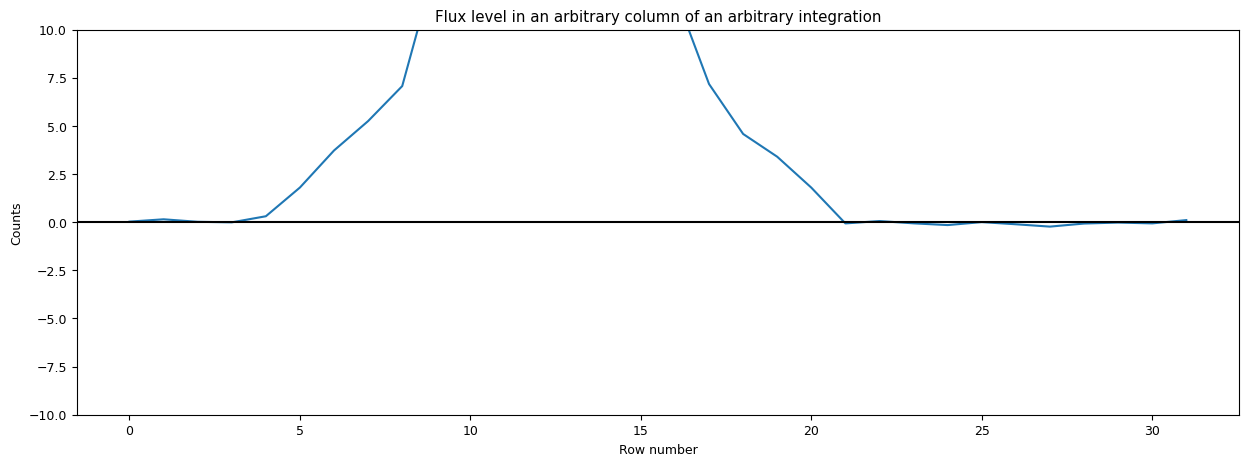

In [12]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg[nint,:,1500])
plt.ylim([-10,10])
plt.axhline(0., color='k')
plt.xlabel('Row number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary column of an arbitrary integration')

Saving the data:

In [13]:
np.save(pout + '/Corrected_data_nrs1.npy', corrected_data_bkg)
np.save(pout + '/Corrected_err_nrs1.npy', corrected_errs)
np.save(pout + '/Mask_bcr_nrs1.npy', mask_bcr)
np.save(pout + '/times_nrs1.npy', times_bjd)